In [85]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt

#### Klasa bazowa Layer
Reprezentuje ogólną warstwę sieci neuronowej z metodami forward i backward.

#### Klasa Linear
Warstwa liniowa (fully connected) wykonująca transformację y = Wx + b i obsługująca propagację wsteczną.


In [86]:

class Layer:
    def forward(self, input):
        pass

    def backward(self, grad_output, lr):
        pass


class Linear(Layer):
    def __init__(self, input_dim, output_dim, weight_init_std=0.01):
        self.W = np.random.randn(output_dim, input_dim) * weight_init_std 
        self.b = np.zeros((output_dim, 1))
        self.x = None

    def forward(self, x):
        self.x = x
        return np.dot(self.W, x) + self.b

    def backward(self, grad_output, lr):
        dW = np.dot(grad_output, self.x.T)
        db = np.sum(grad_output, axis=1, keepdims=True)
        dx = np.dot(self.W.T, grad_output)

        self.W -= lr * dW
        self.b -= lr * db

        return dx

#### Funkcje aktywacji

In [87]:

class ReLU(Layer):
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, grad_output, lr):
        return grad_output * (self.x > 0)
    

class Sigmoid(Layer):
    def forward(self, x):
        self.y = 1 / (1 + np.exp(-x))
        return self.y

    def backward(self, grad_output, lr):
        return grad_output * self.y * (1 - self.y)

#### Siec neuronowa

In [ ]:
class NeuralNetwork:
    def __init__(self, layers, lr=0.01, epochs=100, batch_size=32):
        """
        layers: lista obiektów Layer (np. Linear, ReLU, Sigmoid)
        lr: learning rate
        epochs: liczba epok
        batch_size: wielkość batcha
        """
        self.layers: list[Layer] = layers
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def backward(self, dloss):
        grad = dloss
        for layer in reversed(self.layers):
            grad = layer.backward(grad, self.lr)
        return grad

    def compute_loss(self, pred, target, eps=1e-12):
        pred = np.clip(pred, eps, 1 - eps)
        batch = pred.shape[1]
        loss = - (target * np.log(pred) + (1 - target) * np.log(1 - pred))
        return np.sum(loss) / batch

    def compute_loss_grad(self, pred, target, eps=1e-12):
        pred = np.clip(pred, eps, 1 - eps)
        batch = pred.shape[1]
        grad = (-(target / pred) + ((1 - target) / (1 - pred))) / batch
        return grad

    def accuracy(self, pred, target):
        return np.mean((pred >= 0.5).astype(int) == target)

    def fit(self, X_train, y_train, X_val=None, y_val=None, print_every=10):
        """
        X_train, y_train: dane treningowe (kształt: (features, samples))
        X_val, y_val: opcjonalne dane walidacyjne
        """
        n_samples = X_train.shape[1]

        for epoch in range(1, self.epochs + 1):
            perm = np.random.permutation(n_samples)
            X_sh = X_train[:, perm]
            y_sh = y_train[:, perm]

            # mini-batch loop
            for i in range(0, n_samples, self.batch_size):
                xb = X_sh[:, i:i+self.batch_size]
                yb = y_sh[:, i:i+self.batch_size]

                out = self.forward(xb)
                grad_out = self.compute_loss_grad(out, yb)
                self.backward(grad_out)


            train_pred = self.forward(X_train)
            train_loss = self.compute_loss(train_pred, y_train)
            train_acc = self.accuracy(train_pred, y_train)

            if X_val is not None:
                val_pred = self.forward(X_val)
                val_loss = self.compute_loss(val_pred, y_val)
                val_acc = self.accuracy(val_pred, y_val)
            else:
                val_loss = val_acc = None

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            if epoch % print_every == 0 or epoch == 1 or epoch == self.epochs:
                print(f"Epoch {epoch}/{self.epochs} | Train loss={train_loss:.4f} acc={train_acc:.4f}" +
                      (f" | Val loss={val_loss:.4f} acc={val_acc:.4f}" if val_loss is not None else ""))

    def evaluate(self, X, y):
        pred = self.forward(X)
        loss = self.compute_loss(pred, y)
        acc = self.accuracy(pred, y)
        return loss, acc
    
    def predict(self, X):
        out = self.forward(X)
        return (out >= 0.5).astype(int)


#### Funkcja load_and_prepare_data
Wczytuje dane o chorobie serca, koduje zmienne kategoryczne, dzieli na zbiór treningowy i testowy, opcjonalnie normalizuje i zwraca macierze transponowane gotowe do sieci neuronowej.


In [89]:
def load_and_prepare_data(normalize=True):
    """Wczytuje dane"""
    heart_disease = fetch_ucirepo(id=45)
    X = heart_disease.data.features
    y = heart_disease.data.targets['num']
    y = y.apply(lambda x: 0 if x == 0 else 1)
    
    categorical_cols = heart_disease.variables[
        heart_disease.variables['type'] == 'Categorical'
    ]['name'].tolist()
    
    X = X.dropna()
    y = y[X.index]
    X_encoded = pd.get_dummies(X, columns=categorical_cols, dtype=int)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y, test_size=0.2, random_state=42, stratify=y
    )
    
    if normalize:
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train.values
        X_test_scaled = X_test.values
    
    X_train_t = X_train_scaled.T
    y_train_t = np.array(y_train).reshape(1, -1)
    X_test_t = X_test_scaled.T
    y_test_t = np.array(y_test).reshape(1, -1)
    
    return X_train_t, y_train_t, X_test_t, y_test_t, X_encoded.shape[1]

#### Przekład użycia sieci neuronowej

Epoch 1/1000 | Train loss=0.6931 acc=0.5401 | Val loss=0.6931 acc=0.5333
Epoch 50/1000 | Train loss=0.6888 acc=0.5401 | Val loss=0.6894 acc=0.5333
Epoch 100/1000 | Train loss=0.6745 acc=0.5401 | Val loss=0.6747 acc=0.5333
Epoch 150/1000 | Train loss=0.5864 acc=0.8228 | Val loss=0.5825 acc=0.7833
Epoch 200/1000 | Train loss=0.4433 acc=0.8354 | Val loss=0.4302 acc=0.8167
Epoch 250/1000 | Train loss=0.3959 acc=0.8397 | Val loss=0.3767 acc=0.8167
Epoch 300/1000 | Train loss=0.3814 acc=0.8354 | Val loss=0.3618 acc=0.8333
Epoch 350/1000 | Train loss=0.3731 acc=0.8312 | Val loss=0.3525 acc=0.8500
Epoch 400/1000 | Train loss=0.3669 acc=0.8354 | Val loss=0.3449 acc=0.8500
Epoch 450/1000 | Train loss=0.3620 acc=0.8354 | Val loss=0.3394 acc=0.8500
Epoch 500/1000 | Train loss=0.3578 acc=0.8354 | Val loss=0.3345 acc=0.8500
Epoch 550/1000 | Train loss=0.3543 acc=0.8354 | Val loss=0.3296 acc=0.8500
Epoch 600/1000 | Train loss=0.3511 acc=0.8397 | Val loss=0.3253 acc=0.8500
Epoch 650/1000 | Train loss=

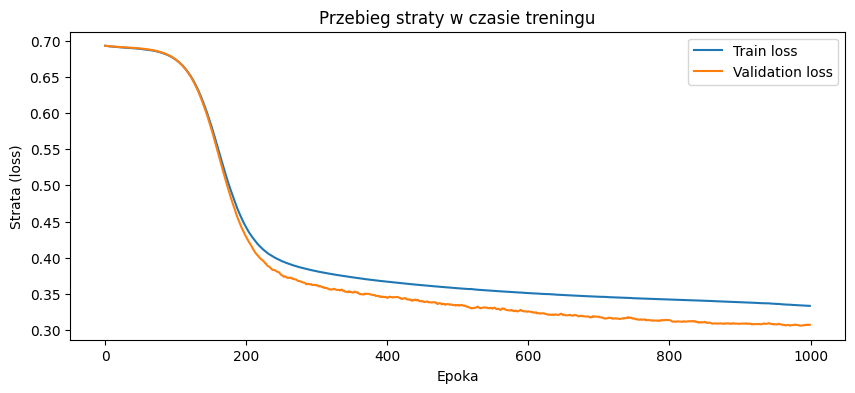

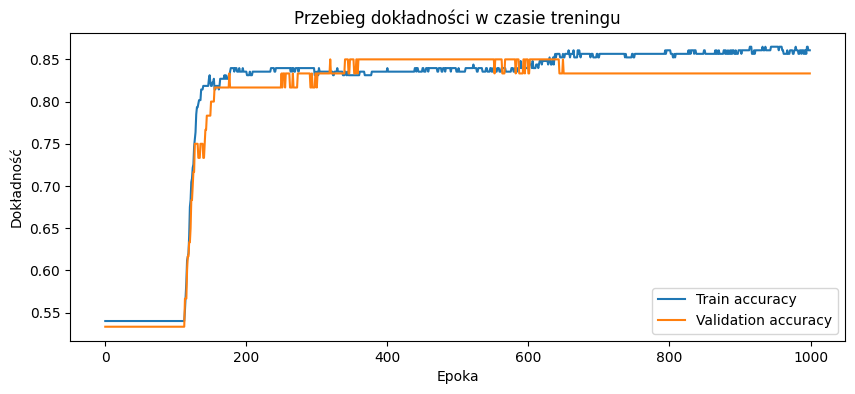

In [90]:
X_train_t, y_train_t, X_test_t, y_test_t, input_dim = load_and_prepare_data(normalize=True)

layers = [
    Linear(input_dim, 16),
    ReLU(),
    Linear(16, 1),
    Sigmoid()
]

net = NeuralNetwork(layers, lr=0.01, epochs=1000, batch_size=32)


net.fit(X_train_t, y_train_t, X_val=X_test_t, y_val=y_test_t, print_every=50)


#Wykres

# wykres strat
plt.figure(figsize=(10,4))
plt.plot(net.history['train_loss'], label='Train loss')
plt.plot(net.history['val_loss'], label='Validation loss')
plt.xlabel('Epoka')
plt.ylabel('Strata (loss)')
plt.title('Przebieg straty w czasie treningu')
plt.legend()
plt.show()

# wykres dokładności
plt.figure(figsize=(10,4))
plt.plot(net.history['train_acc'], label='Train accuracy')
plt.plot(net.history['val_acc'], label='Validation accuracy')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.title('Przebieg dokładności w czasie treningu')
plt.legend()
plt.show()


#### Funkcja test_parameters
Tworzy i trenuje sieć neuronową z podanymi parametrami warstw, liczbą epok, wielkością batcha i normalizacją danych.


In [91]:
def test_parameters(hidden_dim=16, lr=0.01, weight_std=0.01, 
                    normalize=True, num_hidden_layers=1, epochs=500, batch_size=32):
    """Szybkie testowanie różnych parametrów"""
    
    # Wczytaj dane
    X_train_t, y_train_t, X_test_t, y_test_t, input_dim = load_and_prepare_data(normalize)
    
    # Pierwsza warstwa wejściowa
    layers = [Linear(input_dim, hidden_dim, weight_init_std=weight_std), ReLU()]
    
    # Dodaj dodatkowe warstwy ukryte o tym samym rozmiarze
    for i in range(num_hidden_layers - 1):
        layers.extend([Linear(hidden_dim, hidden_dim, weight_init_std=weight_std), ReLU()])
    
    # Warstwa wyjściowa
    layers.extend([Linear(hidden_dim, 1, weight_init_std=weight_std), Sigmoid()])
    
    # Trenuj
    net = NeuralNetwork(layers, lr=lr, epochs=epochs, batch_size=batch_size)
    net.fit(X_train_t, y_train_t, X_test_t, y_test_t, print_every=100)
    
    return net


# Eksperyment 1: Różne wymiary warstwy ukrytej

### Cel:
Sprawdzić, jak liczba neuronów w warstwie ukrytej wpływa na jakość uczenia sieci neuronowej.

### Ustawienia:
- Warstwy ukryte: `[4, 8, 16, 32, 64]`
- Liczba epok: `500`
- Stałe parametry: `learning rate = 0.01`, `batch_size = 32`
### Wyniki (podsumowanie):
| Hidden dim | Train acc | Val acc |
|------------|-----------|---------|
| 4          | 0.8354    | 0.8333  |
| 8          | 0.8397    | 0.8500  |
| 16         | 0.8397    | 0.8500  |
| 32         | 0.8397    | 0.8500  |
| 64         | 0.8354    | 0.8500  |

### Wnioski:
- Wszystkie modele osiągnęły **podobny końcowy poziom dokładności** (~85%), co oznacza, że problem nie wymaga dużej złożoności modelu.  
- **Większe sieci (32, 64 neuronów)** uczyły się **szybciej** — szybciej spadał *training loss*, ale nie poprawiły końcowej skuteczności.  
- Zbyt mała liczba neuronów (np. 4) powoduje **wolniejsze uczenie**, ale końcowy wynik i tak jest dobry.
- Wzrost liczby neuronów **zwiększa pojemność modelu**, ale **nie zawsze poprawia wyniki**, jeśli dane są proste.

### Ogólny wniosek:
Dla tego zadania wystarczy mała sieć — większe modele nie przynoszą zauważalnych korzyści, a jedynie szybciej się dopasowują do danych. Większe warstwy (32, 64) uczą się szybciej, ale mogą prowadzić do overfittingu, dlatego mniejsze (8–16) są bezpieczniejszym wyborem dla tego zbioru danych.



Hidden dim: 4
Epoch 1/500 | Train loss=0.6930 acc=0.5401 | Val loss=0.6931 acc=0.5333
Epoch 100/500 | Train loss=0.6878 acc=0.5401 | Val loss=0.6886 acc=0.5333
Epoch 200/500 | Train loss=0.5834 acc=0.8228 | Val loss=0.5751 acc=0.8333
Epoch 300/500 | Train loss=0.3976 acc=0.8397 | Val loss=0.3789 acc=0.8167
Epoch 400/500 | Train loss=0.3718 acc=0.8312 | Val loss=0.3541 acc=0.8333
Epoch 500/500 | Train loss=0.3606 acc=0.8354 | Val loss=0.3414 acc=0.8500

Hidden dim: 8
Epoch 1/500 | Train loss=0.6930 acc=0.5401 | Val loss=0.6930 acc=0.5333
Epoch 100/500 | Train loss=0.6853 acc=0.5401 | Val loss=0.6859 acc=0.5333
Epoch 200/500 | Train loss=0.5419 acc=0.8312 | Val loss=0.5291 acc=0.8500
Epoch 300/500 | Train loss=0.3925 acc=0.8397 | Val loss=0.3739 acc=0.8167
Epoch 400/500 | Train loss=0.3701 acc=0.8397 | Val loss=0.3537 acc=0.8333
Epoch 500/500 | Train loss=0.3594 acc=0.8397 | Val loss=0.3404 acc=0.8500

Hidden dim: 16
Epoch 1/500 | Train loss=0.6930 acc=0.5401 | Val loss=0.6931 acc=0.533

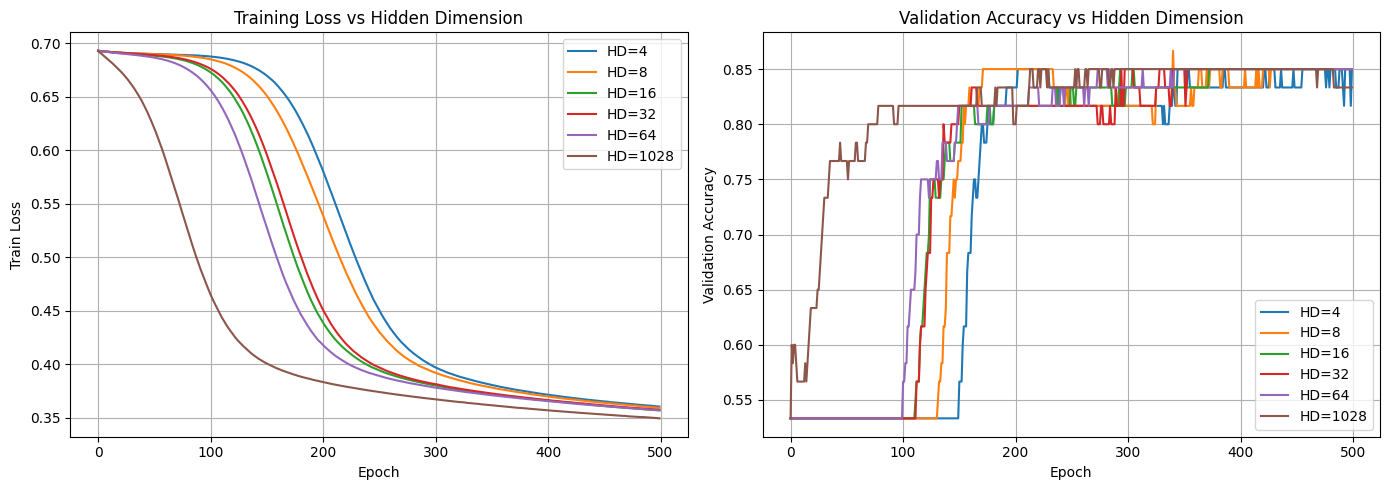


Podsumowanie:
Hidden dim=4: Train acc=0.8354, Val acc=0.8500
Hidden dim=8: Train acc=0.8397, Val acc=0.8500
Hidden dim=16: Train acc=0.8397, Val acc=0.8500
Hidden dim=32: Train acc=0.8354, Val acc=0.8500
Hidden dim=64: Train acc=0.8397, Val acc=0.8500
Hidden dim=1028: Train acc=0.8481, Val acc=0.8333


In [103]:
# EKSPERYMENT 1: Różne wymiary warstwy ukrytej
results = []
hidden_dims = [4, 8, 16, 32, 64, 1028]

for hidden_dim in hidden_dims:
    print(f"\nHidden dim: {hidden_dim}")
    net = test_parameters(hidden_dim=hidden_dim, epochs=500)
    results.append({
        'hidden_dim': hidden_dim,
        'train_acc': net.history['train_acc'][-1],
        'val_acc': net.history['val_acc'][-1],
        'history': net.history
    })

# Wykres
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for r in results:
    axes[0].plot(r['history']['train_loss'], label=f"HD={r['hidden_dim']}")
    axes[1].plot(r['history']['val_acc'], label=f"HD={r['hidden_dim']}")

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Train Loss')
axes[0].set_title('Training Loss vs Hidden Dimension')
axes[0].legend()
axes[0].grid(True)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Validation Accuracy vs Hidden Dimension')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Podsumowanie
print("\nPodsumowanie:")
for r in results:
    print(f"Hidden dim={r['hidden_dim']}: Train acc={r['train_acc']:.4f}, Val acc={r['val_acc']:.4f}")

# Eksperyment 2: Różne learning rates

### Cel:
Sprawdzić, jak szybkość uczenia (*learning rate*) wpływa na proces trenowania i końcową skuteczność sieci neuronowej.

### Ustawienia:
- Learning rates: `[0.001, 0.005, 0.01, 0.05, 0.1, 0.3]`
- Liczba epok: `500`
- Stałe parametry: `hidden_dim = 16`, `batch_size = 32`

### Wyniki (podsumowanie):
| Learning rate | Train acc | Val acc |
|----------------|------------|----------|
| 0.001 | 0.5401 | 0.5333 |
| 0.005 | 0.8354 | 0.8333 |
| 0.01 | 0.8397 | 0.8500 |
| 0.05 | 0.8776 | 0.8500 |
| 0.1 | 0.9030 | 0.8167 |
| 0.3 | 0.9789 | 0.7833 |

### Wnioski:
- **Mały learning rate (0.001)** prowadzi do bardzo **wolnego uczenia** – model praktycznie nie poprawia wyników.  
- **Średnie wartości (0.005–0.05)** dają **najstabilniejsze i najlepsze wyniki** na zbiorze walidacyjnym (~85%).  
- **Zbyt duży learning rate (0.1–0.3)** powoduje, że model uczy się bardzo szybko, ale jego wyniki walidacyjne zaczynają spadać – co może oznaczać **niestabilność uczenia** lub **overfitting**.  
- Wysoki *learning rate* sprawia, że model robi zbyt duże kroki w kierunku minimum błędu, przez co może „przeskakiwać” dobre rozwiązania i dopasowywać się do szumów danych.

### Ogólny wniosek:
Najbardziej efektywny zakres *learning rate* dla tego zadania to **0.005–0.05** — zapewnia równowagę między szybkością a stabilnością uczenia i dobrą generalizacją modelu.



Learning rate: 0.001
Epoch 1/500 | Train loss=0.6932 acc=0.3586 | Val loss=0.6932 acc=0.3833
Epoch 100/500 | Train loss=0.6921 acc=0.5401 | Val loss=0.6922 acc=0.5333
Epoch 200/500 | Train loss=0.6912 acc=0.5401 | Val loss=0.6916 acc=0.5333
Epoch 300/500 | Train loss=0.6906 acc=0.5401 | Val loss=0.6911 acc=0.5333
Epoch 400/500 | Train loss=0.6901 acc=0.5401 | Val loss=0.6907 acc=0.5333
Epoch 500/500 | Train loss=0.6896 acc=0.5401 | Val loss=0.6903 acc=0.5333

Learning rate: 0.005
Epoch 1/500 | Train loss=0.6931 acc=0.5401 | Val loss=0.6931 acc=0.5333
Epoch 100/500 | Train loss=0.6890 acc=0.5401 | Val loss=0.6897 acc=0.5333
Epoch 200/500 | Train loss=0.6760 acc=0.5401 | Val loss=0.6767 acc=0.5333
Epoch 300/500 | Train loss=0.5949 acc=0.8143 | Val loss=0.5936 acc=0.7500
Epoch 400/500 | Train loss=0.4497 acc=0.8270 | Val loss=0.4388 acc=0.8000
Epoch 500/500 | Train loss=0.3977 acc=0.8354 | Val loss=0.3807 acc=0.8167

Learning rate: 0.01
Epoch 1/500 | Train loss=0.6930 acc=0.5401 | Val lo

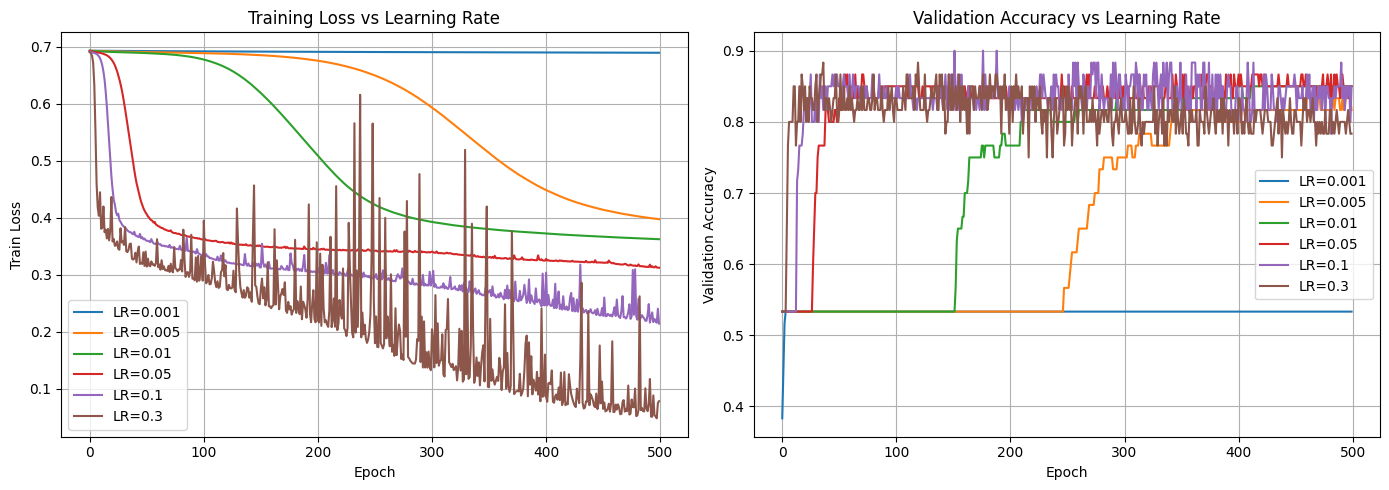


Podsumowanie:
LR=0.001: Train acc=0.5401, Val acc=0.5333
LR=0.005: Train acc=0.8354, Val acc=0.8167
LR=0.01: Train acc=0.8397, Val acc=0.8500
LR=0.05: Train acc=0.8776, Val acc=0.8500
LR=0.1: Train acc=0.9156, Val acc=0.8500
LR=0.3: Train acc=0.9705, Val acc=0.7833


In [93]:
# EKSPERYMENT 2: Różne learning rates
results = []
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3]

for lr in learning_rates:
    print(f"\nLearning rate: {lr}")
    net = test_parameters(lr=lr, epochs=500)
    results.append({
        'lr': lr,
        'train_acc': net.history['train_acc'][-1],
        'val_acc': net.history['val_acc'][-1],
        'history': net.history
    })

# Wykres
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for r in results:
    axes[0].plot(r['history']['train_loss'], label=f"LR={r['lr']}")
    axes[1].plot(r['history']['val_acc'], label=f"LR={r['lr']}")

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Train Loss')
axes[0].set_title('Training Loss vs Learning Rate')
axes[0].legend()
axes[0].grid(True)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Validation Accuracy vs Learning Rate')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Podsumowanie
print("\nPodsumowanie:")
for r in results:
    print(f"LR={r['lr']}: Train acc={r['train_acc']:.4f}, Val acc={r['val_acc']:.4f}")

# **Eksperyment 3: Różne odchylenia standardowe inicjalizacji wag**

### **Cel:**

Sprawdzić, jak wpływa **początkowa skala wag (odchylenie standardowe inicjalizacji)** na proces uczenia i ostateczne wyniki sieci neuronowej.

### **Ustawienia:**

* Odchylenia standardowe wag: `[0.001, 0.01, 0.1, 0.5, 1.0]`
* Liczba epok: `500`
* Stałe parametry: `learning rate = 0.01`, `hidden_dim = 16`, `batch_size = 32`

---

### **Wyniki (podsumowanie):**

| Weight STD | Train acc | Val acc |
| ---------- | --------- | ------- |
| 0.001      | 0.5401    | 0.5333  |
| 0.01       | 0.5401    | 0.5333  |
| 0.1        | 0.8523    | 0.8167  |
| 0.5        | 0.9072    | 0.7833  |
| 1.0        | 0.9114    | 0.8000  |

---

### **Wnioski:**

* **Zbyt małe odchylenie (np. 0.001–0.01)** powoduje, że wszystkie wagi są bardzo podobne — sieć praktycznie nie uczy się (brak różnic w gradientach).
* **Średnie wartości (0.1)** umożliwiają efektywne uczenie — model zbiega stabilnie i osiąga dobre wyniki.
* **Duże odchylenia (0.5–1.0)** powodują duże aktywacje i niestabilne wartości strat — sieć szybko dopasowuje się do danych treningowych, ale **traci zdolność generalizacji (overfitting)**.

---

### **Ogólny wniosek:**

Zbyt małe wagi spowalniają lub całkowicie blokują uczenie, a zbyt duże prowadzą do przeuczenia i niestabilności.
Najlepszy kompromis między stabilnością a skutecznością uzyskano dla **std ≈ 0.1**.



Weight std: 0.001
Epoch 1/500 | Train loss=0.6930 acc=0.5401 | Val loss=0.6931 acc=0.5333
Epoch 100/500 | Train loss=0.6900 acc=0.5401 | Val loss=0.6909 acc=0.5333
Epoch 200/500 | Train loss=0.6899 acc=0.5401 | Val loss=0.6910 acc=0.5333
Epoch 300/500 | Train loss=0.6899 acc=0.5401 | Val loss=0.6910 acc=0.5333
Epoch 400/500 | Train loss=0.6899 acc=0.5401 | Val loss=0.6910 acc=0.5333
Epoch 500/500 | Train loss=0.6899 acc=0.5401 | Val loss=0.6910 acc=0.5333

Weight std: 0.01
Epoch 1/500 | Train loss=0.6931 acc=0.5401 | Val loss=0.6931 acc=0.5333
Epoch 100/500 | Train loss=0.6900 acc=0.5401 | Val loss=0.6909 acc=0.5333
Epoch 200/500 | Train loss=0.6899 acc=0.5401 | Val loss=0.6910 acc=0.5333
Epoch 300/500 | Train loss=0.6899 acc=0.5401 | Val loss=0.6910 acc=0.5333
Epoch 400/500 | Train loss=0.6899 acc=0.5401 | Val loss=0.6910 acc=0.5333
Epoch 500/500 | Train loss=0.6899 acc=0.5401 | Val loss=0.6910 acc=0.5333

Weight std: 0.1
Epoch 1/500 | Train loss=0.6902 acc=0.5485 | Val loss=0.6904 a

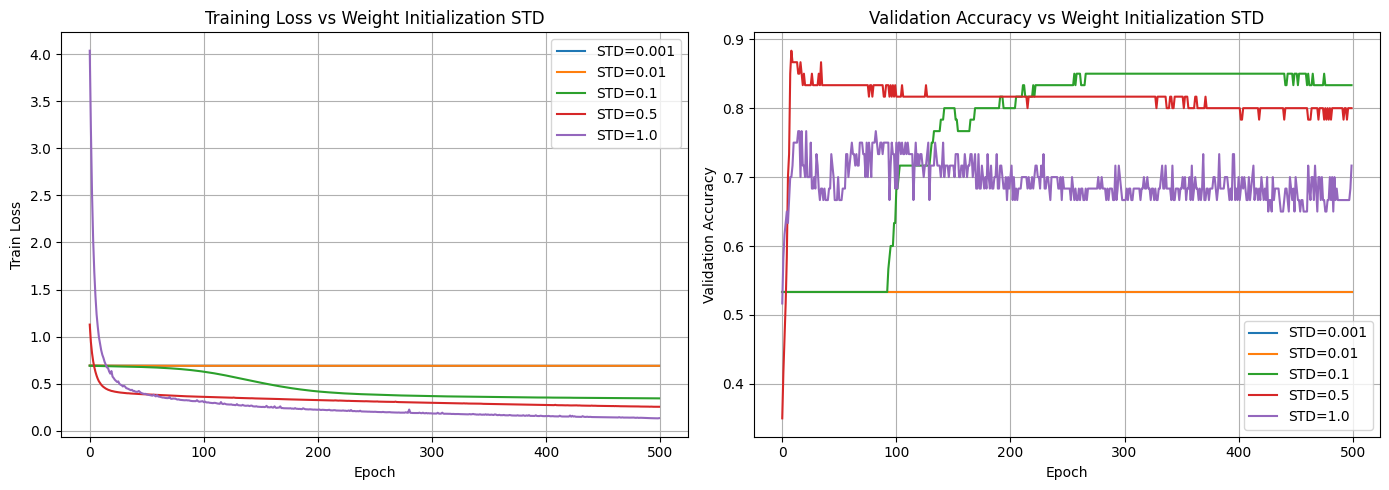


Podsumowanie:
Weight STD=0.001: Train acc=0.5401, Val acc=0.5333
Weight STD=0.01: Train acc=0.5401, Val acc=0.5333
Weight STD=0.1: Train acc=0.8608, Val acc=0.8333
Weight STD=0.5: Train acc=0.9072, Val acc=0.8000
Weight STD=1.0: Train acc=0.9409, Val acc=0.7167


In [99]:
 # EKSPERYMENT 3: Różne odchylenia standardowe inicjalizacji wag
results = []
weight_stds = [0.001, 0.01, 0.1, 0.5, 1.0]

for std in weight_stds:
    print(f"\nWeight std: {std}")
    net = test_parameters(weight_std=std, epochs=500, num_hidden_layers=2)
    results.append({
        'std': std,
        'train_acc': net.history['train_acc'][-1],
        'val_acc': net.history['val_acc'][-1],
        'history': net.history
    })

# Wykres
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for r in results:
    axes[0].plot(r['history']['train_loss'], label=f"STD={r['std']}")
    axes[1].plot(r['history']['val_acc'], label=f"STD={r['std']}")

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Train Loss')
axes[0].set_title('Training Loss vs Weight Initialization STD')
axes[0].legend()
axes[0].grid(True)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Validation Accuracy vs Weight Initialization STD')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Podsumowanie
print("\nPodsumowanie:")
for r in results:
    print(f"Weight STD={r['std']}: Train acc={r['train_acc']:.4f}, Val acc={r['val_acc']:.4f}")

# EKSPERYMENT 4: Dane znormalizowane vs nieznormalizowane

### Cel:

Sprawdzić, jak wpływa **normalizacja danych wejściowych** na proces uczenia sieci neuronowej.

### Ustawienia:

* Liczba epok: `500`
* Stałe parametry: `learning rate = 0.01`, `hidden_dim = 16`, `batch_size = 32`
* Porównano dwa przypadki:
  - Dane **nieznormalizowane**
  - Dane **znormalizowane** (średnia = 0, odchylenie standardowe = 1)

### Wyniki (podsumowanie):

| Dane              | Train acc | Val acc |
| ----------------- | ---------- | -------- |
| Nieznormalizowane | 0.5401     | 0.5333   |
| Znormalizowane    | 0.8397     | 0.8500   |

### Obserwacje:

* Dla **danych nieznormalizowanych** na początku widać duże skoki wartości strat (loss), a potem model bardzo szybko się stabilizuje — ale niestety na **niskim poziomie dokładności**.  
  Po kilku krokach uczenie praktycznie **przestaje działać**, bo sieć nie jest w stanie dalej poprawiać wyników.  
  Wynika to z tego, że **cechy mają różne skale**, przez co **gradienty są niestabilne**, a **wagi aktualizują się nierównomiernie**. Niektóre neurony się „nasycają”, przez co gradienty stają się bardzo małe (bliskie zeru) i sieć praktycznie przestaje aktualizować wagi.
* Dla **danych znormalizowanych** uczenie przebiega dużo płynniej — strata stopniowo maleje, a dokładność rośnie i stabilizuje się na wysokim poziomie.

### Wniosek:

Normalizacja danych sprawia, że sieć uczy się szybciej, stabilniej i osiąga lepsze wyniki.  
Bez normalizacji wartości wejściowe są w różnych zakresach, przez co sieć „gubi się” na początku i bardzo szybko przestaje się uczyć.  



Normalize: False
Epoch 1/500 | Train loss=0.6877 acc=0.5401 | Val loss=0.6860 acc=0.5333
Epoch 100/500 | Train loss=0.6902 acc=0.5401 | Val loss=0.6910 acc=0.5333
Epoch 200/500 | Train loss=0.6899 acc=0.5401 | Val loss=0.6909 acc=0.5333
Epoch 300/500 | Train loss=0.6899 acc=0.5401 | Val loss=0.6910 acc=0.5333
Epoch 400/500 | Train loss=0.6899 acc=0.5401 | Val loss=0.6910 acc=0.5333
Epoch 500/500 | Train loss=0.6899 acc=0.5401 | Val loss=0.6910 acc=0.5333

Normalize: True
Epoch 1/500 | Train loss=0.6930 acc=0.5401 | Val loss=0.6931 acc=0.5333
Epoch 100/500 | Train loss=0.6803 acc=0.5401 | Val loss=0.6811 acc=0.5333
Epoch 200/500 | Train loss=0.4678 acc=0.8270 | Val loss=0.4584 acc=0.8000
Epoch 300/500 | Train loss=0.3846 acc=0.8397 | Val loss=0.3662 acc=0.8333
Epoch 400/500 | Train loss=0.3691 acc=0.8354 | Val loss=0.3467 acc=0.8500
Epoch 500/500 | Train loss=0.3597 acc=0.8397 | Val loss=0.3338 acc=0.8500


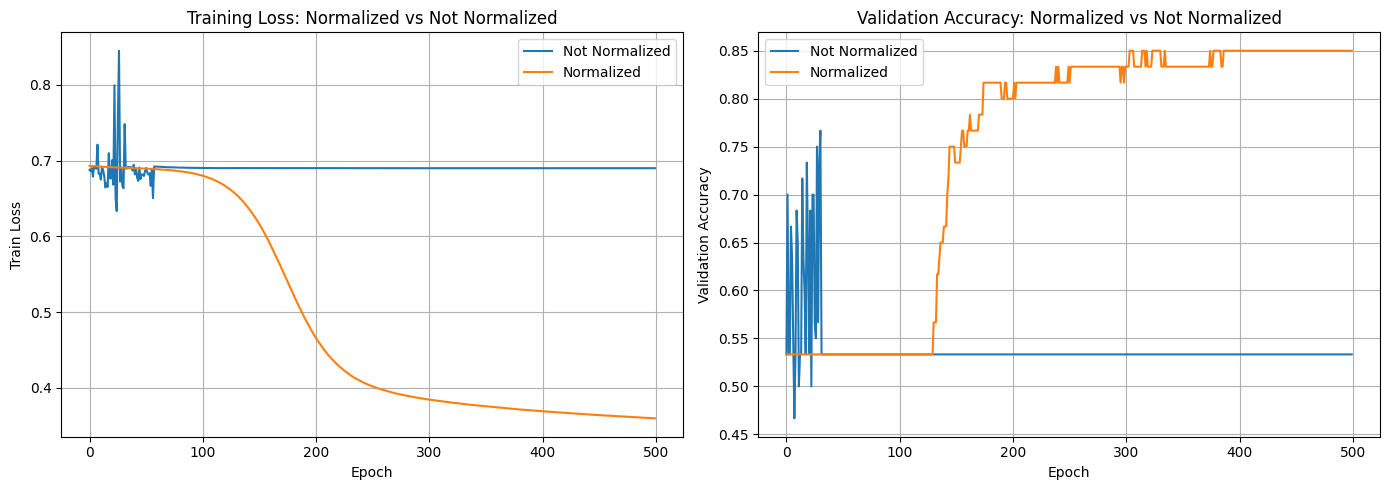


Podsumowanie:
Not Normalized: Train acc=0.5401, Val acc=0.5333
Normalized: Train acc=0.8397, Val acc=0.8500


In [95]:
# EKSPERYMENT 4: Dane znormalizowane vs nieznormalizowane
results = []

for normalize in [False, True]:
    print(f"\nNormalize: {normalize}")
    net = test_parameters(normalize=normalize, epochs=500)
    results.append({
        'normalize': normalize,
        'train_acc': net.history['train_acc'][-1],
        'val_acc': net.history['val_acc'][-1],
        'history': net.history
    })

# Wykres
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for r in results:
    label = "Normalized" if r['normalize'] else "Not Normalized"
    axes[0].plot(r['history']['train_loss'], label=label)
    axes[1].plot(r['history']['val_acc'], label=label)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Train Loss')
axes[0].set_title('Training Loss: Normalized vs Not Normalized')
axes[0].legend()
axes[0].grid(True)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Validation Accuracy: Normalized vs Not Normalized')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Podsumowanie
print("\nPodsumowanie:")
for r in results:
    label = "Normalized" if r['normalize'] else "Not Normalized"
    print(f"{label}: Train acc={r['train_acc']:.4f}, Val acc={r['val_acc']:.4f}")

# EKSPERYMENT 5: Różna liczba warstw ukrytych

### Cel:
Sprawdzić, jak **liczba warstw ukrytych** wpływa na uczenie się sieci oraz końcową dokładność.

### Ustawienia:
* Liczba warstw ukrytych: `[1, 2, 3, 4]`
* Liczba epok: `500`
* Inne parametry: `hidden_dim=16`, `learning rate=0.01`, `weight_std=0.3`, `batch_size=32`

### Wyniki (podsumowanie):

| Hidden layers | Train acc | Val acc |
| ------------- | --------- | ------- |
| 1             | 0.8608    | 0.8500  |
| 2             | 0.8861    | 0.8167  |
| 3             | 0.9241    | 0.8333  |
| 4             | 0.9325    | 0.8167  |

### Wnioski:
* **Jedna warstwa** daje stabilne uczenie i dobrą dokładność.
* **Więcej warstw** pozwala sieci uczyć się szybciej i osiągać wyższe wyniki na zbiorze treningowym, ale pojawia się **ryzyko overfittingu** (dokładność walidacji nie rośnie proporcjonalnie do treningowej).
* Widzimy, że dla 2, 3 i 4 warstw dokładność walidacji spada w stosunku do treningowej — typowy efekt **przeuczenia przy większej liczbie parametrów**.

### Uwagi:
* Wcześniej dla małych wag (`weight_std=0.01`) gradienty zanikły i sieć nie uczyła się dla >1 warstwy.
* Zwiększenie `weight_std` do 0.3 pozwala sygnałowi przepływać przez więcej warstw i poprawnie uczyć się sieci głębszych.


Number of hidden layers: 1
Epoch 1/500 | Train loss=0.6679 acc=0.6118 | Val loss=0.6513 acc=0.6167
Epoch 100/500 | Train loss=0.3984 acc=0.8354 | Val loss=0.3613 acc=0.8500
Epoch 200/500 | Train loss=0.3707 acc=0.8397 | Val loss=0.3347 acc=0.8333
Epoch 300/500 | Train loss=0.3554 acc=0.8439 | Val loss=0.3234 acc=0.8500
Epoch 400/500 | Train loss=0.3448 acc=0.8481 | Val loss=0.3133 acc=0.8500
Epoch 500/500 | Train loss=0.3358 acc=0.8481 | Val loss=0.3096 acc=0.8333

Number of hidden layers: 2
Epoch 1/500 | Train loss=0.6843 acc=0.5823 | Val loss=0.6921 acc=0.6167
Epoch 100/500 | Train loss=0.3779 acc=0.8270 | Val loss=0.3774 acc=0.8500
Epoch 200/500 | Train loss=0.3445 acc=0.8608 | Val loss=0.3537 acc=0.8333
Epoch 300/500 | Train loss=0.3187 acc=0.8776 | Val loss=0.3348 acc=0.8667
Epoch 400/500 | Train loss=0.2938 acc=0.8945 | Val loss=0.3243 acc=0.8500
Epoch 500/500 | Train loss=0.2714 acc=0.9072 | Val loss=0.3230 acc=0.8500

Number of hidden layers: 3
Epoch 1/500 | Train loss=0.7345 

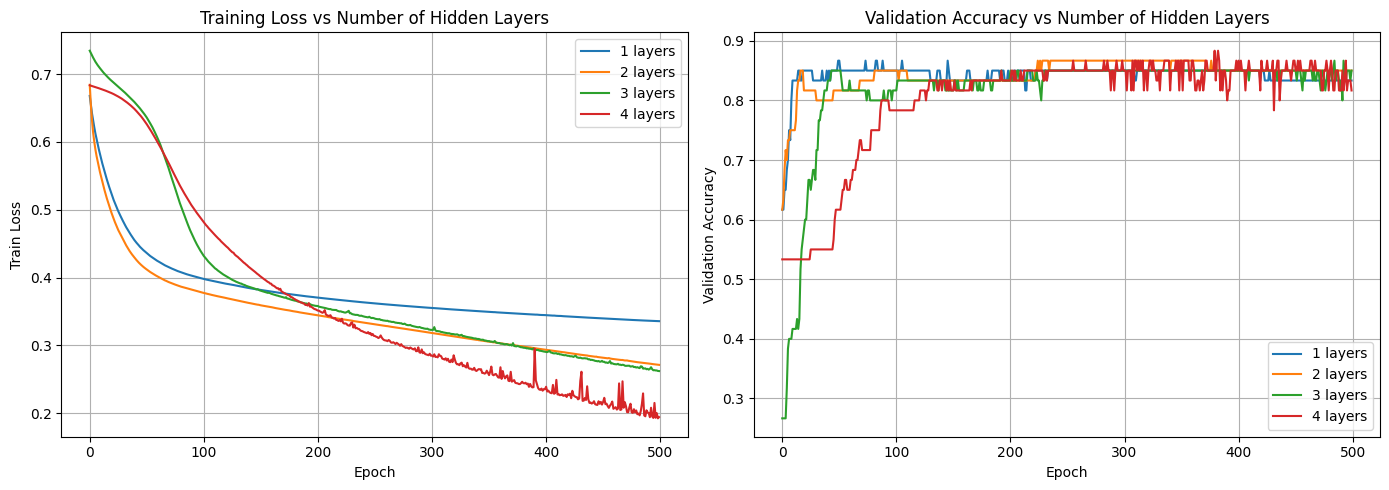


Podsumowanie:
1 layers: Train acc=0.8481, Val acc=0.8333
2 layers: Train acc=0.9072, Val acc=0.8500
3 layers: Train acc=0.9072, Val acc=0.8500
4 layers: Train acc=0.9198, Val acc=0.8167


In [96]:
# EKSPERYMENT 5: Różna liczba warstw ukrytych
results = []
num_layers_list = [1, 2, 3, 4]

for num_layers in num_layers_list:
    print(f"\nNumber of hidden layers: {num_layers}")
    net = test_parameters(num_hidden_layers=num_layers, epochs=500, weight_std=0.3)
    results.append({
        'num_layers': num_layers,
        'train_acc': net.history['train_acc'][-1],
        'val_acc': net.history['val_acc'][-1],
        'history': net.history
    })

# Wykres
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for r in results:
    axes[0].plot(r['history']['train_loss'], label=f"{r['num_layers']} layers")
    axes[1].plot(r['history']['val_acc'], label=f"{r['num_layers']} layers")

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Train Loss')
axes[0].set_title('Training Loss vs Number of Hidden Layers')
axes[0].legend()
axes[0].grid(True)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Validation Accuracy vs Number of Hidden Layers')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Podsumowanie
print("\nPodsumowanie:")
for r in results:
    print(f"{r['num_layers']} layers: Train acc={r['train_acc']:.4f}, Val acc={r['val_acc']:.4f}")

### EKSPERYMENT KOŃCOWY: Porównanie najlepszych konfiguracji z każdego eksperymentu

EKSPERYMENT KOŃCOWY: Porównanie najlepszych konfiguracji

Testowanie: Baseline (1 warstwa, lr=0.01)
  hidden_dim=16, lr=0.01, weight_std=0.01, layers=1
Epoch 1/500 | Train loss=0.6930 acc=0.5401 | Val loss=0.6930 acc=0.5333
Epoch 100/500 | Train loss=0.6780 acc=0.5401 | Val loss=0.6786 acc=0.5333
Epoch 200/500 | Train loss=0.4640 acc=0.8270 | Val loss=0.4506 acc=0.8167
Epoch 300/500 | Train loss=0.3825 acc=0.8354 | Val loss=0.3656 acc=0.8333
Epoch 400/500 | Train loss=0.3669 acc=0.8397 | Val loss=0.3498 acc=0.8500
Epoch 500/500 | Train loss=0.3576 acc=0.8397 | Val loss=0.3368 acc=0.8500

Testowanie: Mała sieć (8 neuronów)
  hidden_dim=8, lr=0.01, weight_std=0.01, layers=1
Epoch 1/500 | Train loss=0.6930 acc=0.5401 | Val loss=0.6930 acc=0.5333
Epoch 100/500 | Train loss=0.6861 acc=0.5401 | Val loss=0.6867 acc=0.5333
Epoch 200/500 | Train loss=0.5532 acc=0.8228 | Val loss=0.5418 acc=0.8500
Epoch 300/500 | Train loss=0.3941 acc=0.8397 | Val loss=0.3770 acc=0.8167
Epoch 400/500 | Train los

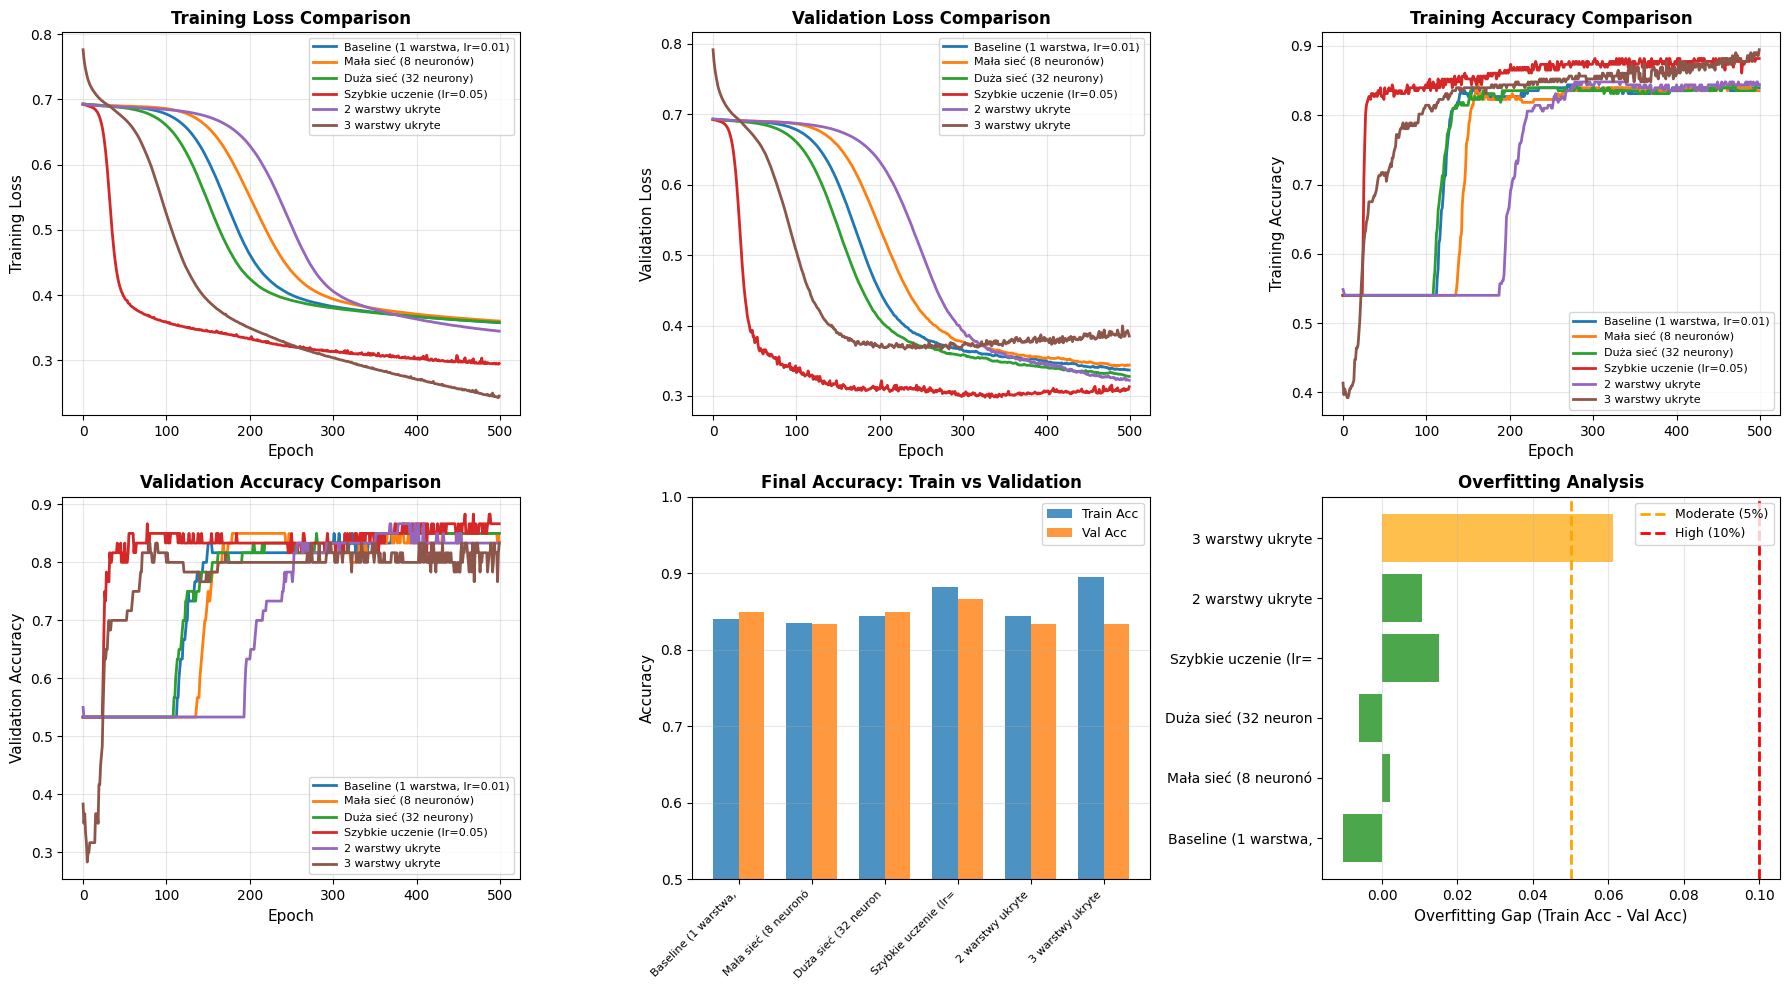


PODSUMOWANIE KOŃCOWE
Konfiguracja                         Train Acc    Val Acc      Gap   Train Loss     Val Loss
----------------------------------------------------------------------------------------------------
Baseline (1 warstwa, lr=0.01)           0.8397     0.8500  -0.0103       0.3576       0.3368
Mała sieć (8 neuronów)                  0.8354     0.8333   0.0021       0.3601       0.3438
Duża sieć (32 neurony)                  0.8439     0.8500  -0.0061       0.3580       0.3277
Szybkie uczenie (lr=0.05)               0.8819     0.8667   0.0152       0.2949       0.3130
2 warstwy ukryte                        0.8439     0.8333   0.0105       0.3445       0.3222
3 warstwy ukryte                        0.8945     0.8333   0.0612       0.2450       0.3851

🏆 NAJLEPSZA DOKŁADNOŚĆ WALIDACYJNA: Szybkie uczenie (lr=0.05)
   Val Acc: 0.8667, Train Acc: 0.8819, Gap: 0.0152

✅ NAJLEPSZA GENERALIZACJA (najmniejszy gap): Baseline (1 warstwa, lr=0.01)
   Gap: -0.0103, Val Acc: 0.8500, Tr

In [97]:
#Wygenerowany kod przez LLM

# ============================================================================
# EKSPERYMENT KOŃCOWY: Porównanie najlepszych konfiguracji z każdego eksperymentu
# ============================================================================

print("="*80)
print("EKSPERYMENT KOŃCOWY: Porównanie najlepszych konfiguracji")
print("="*80)

# Konfiguracje do przetestowania (na podstawie wcześniejszych eksperymentów)
configs = [
    # Nazwa, hidden_dim, lr, weight_std, normalize, num_hidden_layers
    ("Baseline (1 warstwa, lr=0.01)", 16, 0.01, 0.01, True, 1),
    ("Mała sieć (8 neuronów)", 8, 0.01, 0.01, True, 1),
    ("Duża sieć (32 neurony)", 32, 0.01, 0.01, True, 1),
    ("Szybkie uczenie (lr=0.05)", 16, 0.05, 0.01, True, 1),
    ("2 warstwy ukryte", 16, 0.01, 0.1, True, 2),
    ("3 warstwy ukryte", 16, 0.01, 0.3, True, 3),
]

results_final = []

for name, hd, lr, ws, norm, nl in configs:
    print(f"\n{'='*60}")
    print(f"Testowanie: {name}")
    print(f"  hidden_dim={hd}, lr={lr}, weight_std={ws}, layers={nl}")
    print(f"{'='*60}")
    
    net = test_parameters(
        hidden_dim=hd, 
        lr=lr, 
        weight_std=ws, 
        normalize=norm, 
        num_hidden_layers=nl, 
        epochs=500
    )
    
    # Oblicz overfitting gap
    train_acc = net.history['train_acc'][-1]
    val_acc = net.history['val_acc'][-1]
    overfit_gap = train_acc - val_acc
    
    results_final.append({
        'name': name,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'overfit_gap': overfit_gap,
        'train_loss': net.history['train_loss'][-1],
        'val_loss': net.history['val_loss'][-1],
        'history': net.history
    })

# ============================================================================
# WYKRESY PORÓWNAWCZE
# ============================================================================

fig = plt.figure(figsize=(18, 10))

# 1. Training Loss
ax1 = plt.subplot(2, 3, 1)
for r in results_final:
    ax1.plot(r['history']['train_loss'], label=r['name'], linewidth=2)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Training Loss', fontsize=11)
ax1.set_title('Training Loss Comparison', fontsize=12, fontweight='bold')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# 2. Validation Loss
ax2 = plt.subplot(2, 3, 2)
for r in results_final:
    ax2.plot(r['history']['val_loss'], label=r['name'], linewidth=2)
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Validation Loss', fontsize=11)
ax2.set_title('Validation Loss Comparison', fontsize=12, fontweight='bold')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# 3. Training Accuracy
ax3 = plt.subplot(2, 3, 3)
for r in results_final:
    ax3.plot(r['history']['train_acc'], label=r['name'], linewidth=2)
ax3.set_xlabel('Epoch', fontsize=11)
ax3.set_ylabel('Training Accuracy', fontsize=11)
ax3.set_title('Training Accuracy Comparison', fontsize=12, fontweight='bold')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# 4. Validation Accuracy
ax4 = plt.subplot(2, 3, 4)
for r in results_final:
    ax4.plot(r['history']['val_acc'], label=r['name'], linewidth=2)
ax4.set_xlabel('Epoch', fontsize=11)
ax4.set_ylabel('Validation Accuracy', fontsize=11)
ax4.set_title('Validation Accuracy Comparison', fontsize=12, fontweight='bold')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

# 5. Overfitting Analysis (Train vs Val Accuracy)
ax5 = plt.subplot(2, 3, 5)
names_short = [r['name'][:20] for r in results_final]
train_accs = [r['train_acc'] for r in results_final]
val_accs = [r['val_acc'] for r in results_final]
x_pos = np.arange(len(names_short))
width = 0.35

bars1 = ax5.bar(x_pos - width/2, train_accs, width, label='Train Acc', alpha=0.8)
bars2 = ax5.bar(x_pos + width/2, val_accs, width, label='Val Acc', alpha=0.8)

ax5.set_ylabel('Accuracy', fontsize=11)
ax5.set_title('Final Accuracy: Train vs Validation', fontsize=12, fontweight='bold')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(names_short, rotation=45, ha='right', fontsize=8)
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3, axis='y')
ax5.set_ylim([0.5, 1.0])

# 6. Overfitting Gap
ax6 = plt.subplot(2, 3, 6)
gaps = [r['overfit_gap'] for r in results_final]
colors = ['green' if gap < 0.05 else 'orange' if gap < 0.10 else 'red' for gap in gaps]

bars = ax6.barh(names_short, gaps, color=colors, alpha=0.7)
ax6.set_xlabel('Overfitting Gap (Train Acc - Val Acc)', fontsize=11)
ax6.set_title('Overfitting Analysis', fontsize=12, fontweight='bold')
ax6.axvline(x=0.05, color='orange', linestyle='--', linewidth=2, label='Moderate (5%)')
ax6.axvline(x=0.10, color='red', linestyle='--', linewidth=2, label='High (10%)')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# ============================================================================
# TABELA PODSUMOWUJĄCA
# ============================================================================

print("\n" + "="*100)
print("PODSUMOWANIE KOŃCOWE")
print("="*100)
print(f"{'Konfiguracja':<35} {'Train Acc':>10} {'Val Acc':>10} {'Gap':>8} {'Train Loss':>12} {'Val Loss':>12}")
print("-"*100)

for r in results_final:
    print(f"{r['name']:<35} {r['train_acc']:>10.4f} {r['val_acc']:>10.4f} "
          f"{r['overfit_gap']:>8.4f} {r['train_loss']:>12.4f} {r['val_loss']:>12.4f}")

print("="*100)

# Znajdź najlepszą konfigurację
best_val = max(results_final, key=lambda x: x['val_acc'])
best_generalization = min(results_final, key=lambda x: x['overfit_gap'])

print(f"\n🏆 NAJLEPSZA DOKŁADNOŚĆ WALIDACYJNA: {best_val['name']}")
print(f"   Val Acc: {best_val['val_acc']:.4f}, Train Acc: {best_val['train_acc']:.4f}, Gap: {best_val['overfit_gap']:.4f}")

print(f"\n✅ NAJLEPSZA GENERALIZACJA (najmniejszy gap): {best_generalization['name']}")
print(f"   Gap: {best_generalization['overfit_gap']:.4f}, Val Acc: {best_generalization['val_acc']:.4f}, Train Acc: {best_generalization['train_acc']:.4f}")

# ============================================================================
# ANALIZA OVERFITTINGU
# ============================================================================

print("\n" + "="*100)
print("ANALIZA OVERFITTINGU")
print("="*100)

for r in results_final:
    gap = r['overfit_gap']
    if gap < 0.03:
        status = "✅ DOBRA GENERALIZACJA"
    elif gap < 0.07:
        status = "⚠️  LEKKI OVERFITTING"
    else:
        status = "❌ SILNY OVERFITTING"
    
    print(f"{r['name']:<35} Gap: {gap:>6.2%}  {status}")

print("="*100)